# cGANs for Function Simulation

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import bbobtorch
import gt_sampling

In [47]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
# Hyperparameters
latent_dim = 2
num_epochs = 1000
batch_size = 64
learning_rate = 0.0002

In [49]:
# create ground truth functions
n_dim = 2
samples = 1000
seed = 42

def create_problem(f_number, n_dim, seed):
    if f_number == 1:
        problem = bbobtorch.create_f01(n_dim, seed=seed)
    elif f_number == 3:
        problem = bbobtorch.create_f03(n_dim, seed=seed)
    elif f_number == 24:
        problem = bbobtorch.create_f24(n_dim, seed=seed)

    return problem

problem_f01 = create_problem(1, n_dim, seed)
problem_f03 = create_problem(3, n_dim, seed)
problem_f24 = create_problem(24, n_dim, seed)

In [50]:
# sampling from groundtruth functions
sample_f01 = gt_sampling.get_sample(problem_f01, n_samples=1000, n_dim=2, seed=42, method='random')
sample_f03 = gt_sampling.get_sample(problem_f03, n_samples=1000, n_dim=2, seed=42, method='random')
sample_f24 = gt_sampling.get_sample(problem_f24, n_samples=1000, n_dim=2, seed=42, method='random')

In [58]:
data = sample_f24
data_tensor = torch.from_numpy(data[0]).to(device, dtype=torch.float32)
condition_labels = torch.tensor(data[1]).to(device, dtype=torch.float32)
dataset = TensorDataset(data_tensor, condition_labels)
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

C:\Users\User\AppData\Local\Temp\ipykernel_13828\3430964571.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  condition_labels = torch.tensor(data[1]).to(device, dtype=torch.float32)


In [59]:
# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + 2, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1)
        )

    def forward(self, z, conditions):
        z = torch.cat((z, conditions), 1)
        return (self.model(z)-1.)*500.


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, conditions):
        x = torch.cat((x, conditions), 1)
        return self.model(x)

In [60]:
# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i, (conditions, real_output) in enumerate(train_loader):
        conditions = conditions.to(device)
        real_output = real_output.to(device)
        bs = conditions.size(0)
        real_labels = torch.ones(bs).to(device)
        fake_labels = torch.zeros(bs).to(device)

        # Train the discriminator
        discriminator.zero_grad()
        real_output = discriminator(real_output[:, None], conditions) 
        real_loss = criterion(real_output.flatten(), real_labels.flatten())

        z = torch.randn(conditions.size(0), latent_dim).to(device)
        fake_inputs = generator(z, conditions)
        fake_output = discriminator(fake_inputs, conditions)
        fake_loss = criterion(fake_output.flatten(), fake_labels.flatten())

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train the generator
        generator.zero_grad()
        z = torch.randn(conditions.size(0), latent_dim).to(device)
        fake_inputs = generator(z, conditions)
        output = discriminator(fake_inputs, conditions)
        g_loss = criterion(output.flatten(), real_labels.flatten())
        g_loss.backward()
        optimizer_G.step()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i+1}/{len(train_loader)}] Loss_D: {d_loss.item():.4f} Loss_G: {g_loss.item():.4f}")

# Save the generator model for later use
torch.save(generator.state_dict(), "cgan_generator.pth")

In [61]:
import sys
sys.path.append('../')
from utils.utils import plot_simulated_meshgrid, plot_collage
import numpy as np

In [62]:
with torch.no_grad():
    x = np.linspace(-5.0, 5.0, 1000)
    y = np.linspace(-5.0, 5.0, 1000)
    X, Y = np.meshgrid(x, y)
    mesh_samples = np.c_[X.ravel(), Y.ravel()]
    mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
    mesh_results = generator(torch.rand(1000**2, latent_dim), mesh_samples_tensor).reshape(X.shape)

<Axes: title={'center': 'Simulated Function from cGAN'}, xlabel='X1', ylabel='X2'>

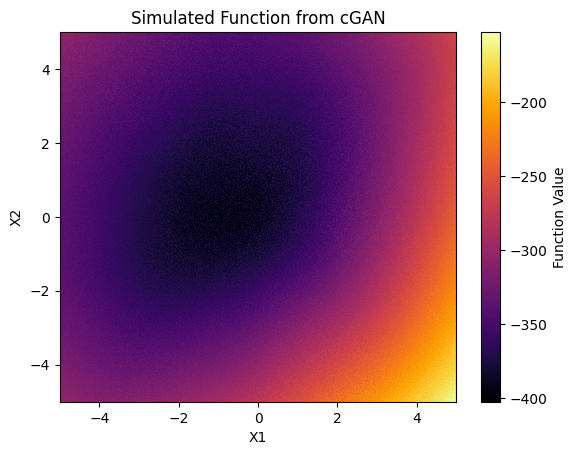

In [63]:
plot_simulated_meshgrid(X, Y, mesh_results, model='cGAN')

<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

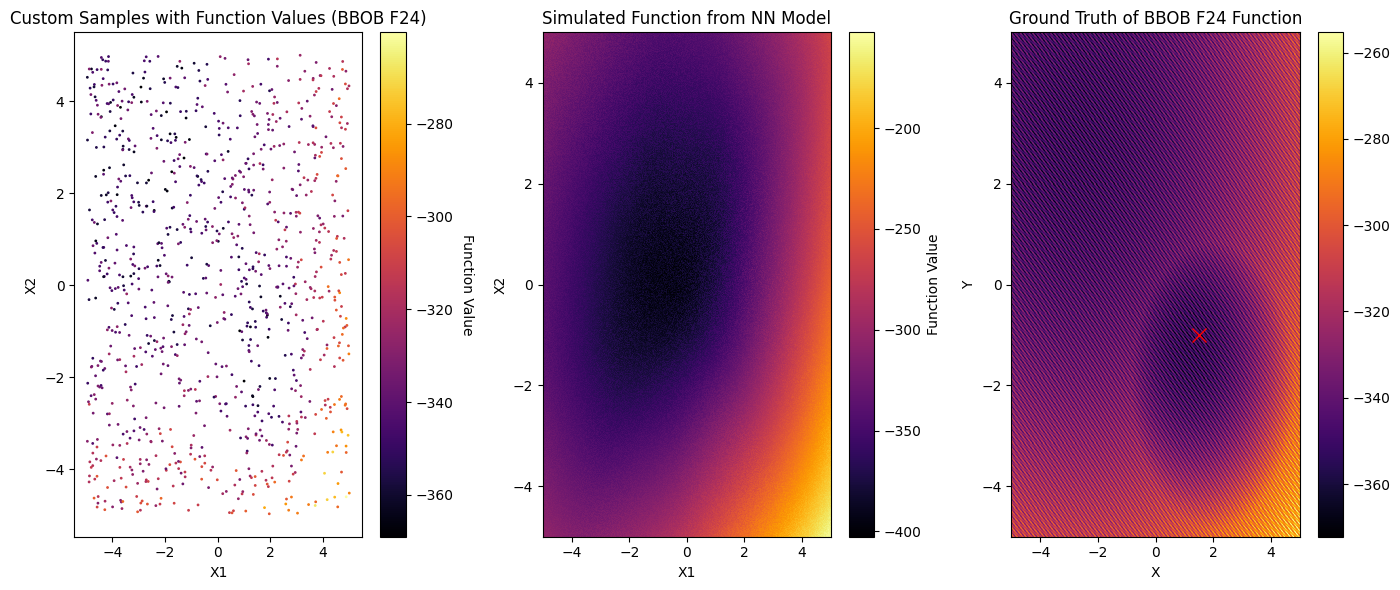

In [64]:
plot_collage(sample_f24[0], sample_f24[1], problem_f24, "BBOB F24", X, Y, mesh_results)